In [81]:
!pip install adversarial-robustness-toolbox


In [0]:
"""
The script demonstrates a simple example of using ART with Keras. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
import matplotlib.pyplot as plt
import numpy as np
import random
import keras

from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential

from art.classifiers import KerasClassifier
from art.attacks import FastGradientMethod, SaliencyMapMethod, DeepFool
from art.utils import load_mnist


In [0]:

def show_img(img, cmap='gray'):
    plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap='gray')
    plt.show()


In [0]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

In [0]:
# Step 1: Load the MNIST dataset
def read_dataset(db_name='fashion'):
  if db_name == 'mnist':
      (x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()         
      names = list(range(10))
  else:
      (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 
      x_train = np.expand_dims(x_train, axis=3)
      x_test = np.expand_dims(x_test, axis=3)
      y_train = to_categorical(y_train)
      y_test = to_categorical(y_test)
      names = [ 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', ]
      x_train = x_train.astype('float32') / 255.
      x_test = x_test.astype('float32') / 255.
  
  return (x_train, y_train), (x_test, y_test), names 
# x.shape, y_train.shape
# >>> (?, 28, 28, 1), (?, 10)

In [0]:
(x_train, y_train), (x_test, y_test), names = read_dataset(db_name='fashion')


In [0]:
min_pix_value = 0
max_pixel_value = 1

In [0]:
# Step 2: Create the model

model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])


In [89]:
# Step 3: Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

# Step 4: Train the ART classifier
hist = classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)


Epoch 1/3
938/937 [==============================] - 24s 26ms/step - loss: 1.3094 - acc: 0.5360
Epoch 2/3
938/937 [==============================] - 24s 26ms/step - loss: 0.7453 - acc: 0.7213
Epoch 3/3
938/937 [==============================] - 24s 26ms/step - loss: 0.6560 - acc: 0.7509


In [0]:

def plot_images(image, noise, noisy_image,
                name_source, name_target,
                score_source, score_source_org, score_target):
    """
    Plot the image, the noisy image and the noise.
    Also shows the class-names and scores.

    Note that the noise is amplified to use the full range of
    colours, otherwise if the noise is very low it would be
    hard to see.

    image: Original input image.
    noise: Noise that has been added to the image.
    noisy_image: Input image + noise.
    name_source: Name of the source-class.
    name_target: Name of the target-class.
    score_source: Score for the source-class.
    score_source_org: Original score for the source-class.
    score_target: Score for the target-class.
    """
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Plot the original image.
    # Note that the pixel-values are normalized to the [0.0, 1.0]
    # range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    # Plot the noisy image.
    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    # Plot the noise.
    # The colours are amplified otherwise they would be hard to see.
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [91]:
# Step 5: Evaluate the ART classifier on benign test examples

preds = classifier.predict(x_test)
accuracy = np.sum(np.argmax(preds, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on benign test examples: {}%'.format(accuracy * 100))

Accuracy on benign test examples: 77.16%


In [94]:

# Step 6: Generate adversarial test examples
# eps = 0.2
eps = 0.15
attack = FastGradientMethod(classifier=classifier, eps=eps)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

noisy_preds = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(noisy_preds, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))


Accuracy on adversarial test examples: 23.56%


3679
correct name:  Bag
adversarial name:  Shirt


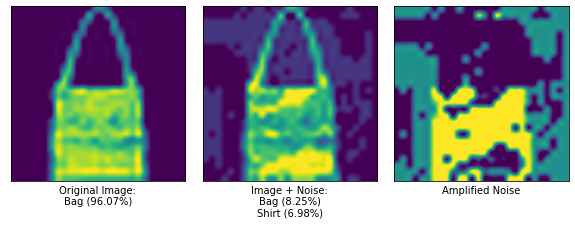

956
correct name:  Pullover
adversarial name:  Bag


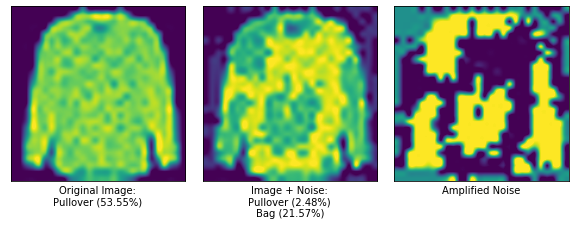

2161
correct name:  Coat
adversarial name:  Shirt


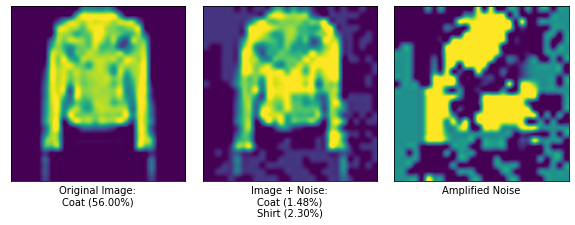

5944
correct name:  Sneaker
adversarial name:  Sandal


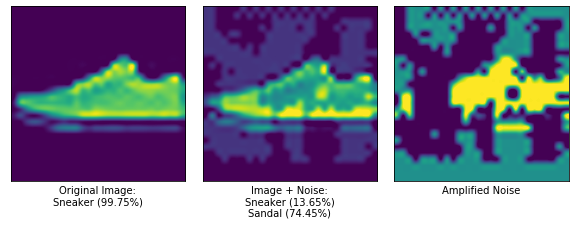

9009
correct name:  Trouser
adversarial name:  Dress


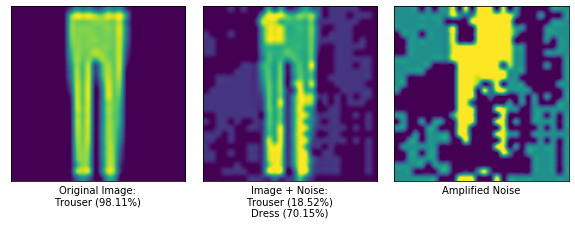

In [95]:
def plot_adversarial_comparisons(x_test, preds, x_test_adv, noisy_preds, sample_count=5):
  indexes = list(range(len(x_test_adv)))
  for i in random.sample(indexes, sample_count):
      print(i)
      j = np.argmax(preds[i])
      shape = (x_test[0].shape[0], x_test[0].shape[1])  # needed to plot the images
  
      # images
      image = x_test[i].reshape(shape)  # original image
      noisy_image = x_test_adv[i].reshape(shape)  # image with noise
  
      # benign image
      target_cls = np.argmax(preds[i])  # index of the class where the benign instance i belongs to
      name_source = names[target_cls]  # predicted class name 
      score_source_org = preds[i][target_cls]  # the probability of the class 
  
      # image with noise
      name_target = names[np.argmax(noisy_preds[i])]  # fooled class name
      score_source = noisy_preds[i][target_cls]  # probability of the true class
  
      noise = image - noisy_image  # compute the augmented noise
      score_target = predictions[i][np.argmax(noisy_preds[i])]  # probability to be the fooled image
  
      print('correct name: ', name_source)
      print('adversarial name: ', name_target)
  
      plot_images(image, noise, noisy_image,
                  name_source, name_target,
                  score_source, score_source_org, score_target)